In [1]:
import sys
sys.path.append('../cace/')

import numpy as np
import torch
import torch.nn as nn
import logging
import ase

import cace
from cace.representations import Cace
from cace.modules import CosineCutoff, MollifierCutoff, PolynomialCutoff
from cace.modules import BesselRBF, GaussianRBF, GaussianRBFCentered

from cace.models.atomistic import NeuralNetworkPotential
from cace.tasks.train import TrainingTask

import matplotlib.pyplot as plt

torch.set_default_dtype(torch.float32)

cace.tools.setup_logger(level='INFO')
cutoff = 4


xyz_path = '../pure-SR-Nacl/Train.xyz'
xyz = ase.io.read(xyz_path,':')
avge0 = cace.tools.compute_average_E0s(xyz)

LLLLL =0.1
val_frac = LLLLL

print("reading data")
collection = cace.tasks.get_dataset_from_xyz(train_path=xyz_path,
                                 valid_fraction=val_frac,
                                 seed=1,
                                 cutoff=cutoff,
                                 data_key={'energy': 'energy', 'forces':'forces'}, 
                                 atomic_energies=avge0 # avg
                                 )
batch_size = 2

train_loader = cace.tasks.load_data_loader(collection=collection,
                              data_type='train',
                              batch_size=batch_size,
                              )

valid_loader = cace.tasks.load_data_loader(collection=collection,
                              data_type='valid',
                              batch_size=4,
                              )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = cace.tools.init_device(use_device)
print(f"device: {device}")

reading data
2025-06-21 19:56:07.948 INFO: Loaded 1001 training configurations from '/dssg/home/acct-matxzl/matxzl/Yajie/MDNN/cace-lr-fit-main_dl/SR-Nacl/Train.xyz'
2025-06-21 19:56:07.948 INFO: Using random 10.0% of training set for validation
device: cuda


In [2]:
cace_nnp=torch.load("/dssg/home/acct-matxzl/matxzl/Yajie/MDNN/cace-lr-fit-main_dl/SR-Nacl/loss_data/SOG0_loss20250510_101131_model.pth")
cace_nnp.to(device)

CombinePotential(
  (models): ModuleList(
    (0): NeuralNetworkPotential(
      (postprocessors): ModuleList()
      (representation): Cace(
        (node_onehot): NodeEncoder(num_classes=2)
        (node_embedding_sender): NodeEmbedding(num_classes=2, embedding_dim=3)
        (node_embedding_receiver): NodeEmbedding(num_classes=2, embedding_dim=3)
        (edge_coding): EdgeEncoder(directed=True)
        (radial_basis): BesselRBF(cutoff=4.0, n_rbf=6, trainable=True)
        (cutoff_fn): PolynomialCutoff(p=6.0, cutoff=4.0)
        (angular_basis): AngularComponent(l_max=3)
        (radial_transform): SharedRadialLinearTransform(
          (weights): ParameterList(
              (0): Parameter containing: [torch.float32 of size 6x12x9 (cuda:0)]
              (1): Parameter containing: [torch.float32 of size 6x12x9 (cuda:0)]
              (2): Parameter containing: [torch.float32 of size 6x12x9 (cuda:0)]
              (3): Parameter containing: [torch.float32 of size 6x12x9 (cuda:0)]
  

In [3]:
sog_potential = cace_nnp.models[1].output_modules[1]  # 定位到 SOGPotential 模块

# 查看参数概览
for name, param in sog_potential.named_parameters():
    print(f"Parameter name: {name}")
    print(f"Shape: {param.shape}")
    print(f"Values sample:\n{param.data}\n")  # 展示前两个参数值

Parameter name: shift_1
Shape: torch.Size([12])
Values sample:
tensor([-1.4412, -1.1342, -0.4853, -0.3446, -0.8474, -0.8561, -0.3425,  0.3399,
         0.4607,  1.3826,  1.5941,  1.6683], device='cuda:0')

Parameter name: amplitude_1
Shape: torch.Size([12])
Values sample:
tensor([ 0.3375,  0.1872,  0.1420,  0.2573, -0.1768, -0.5299, -0.4164, -0.6745,
        -0.7429, -0.1479,  0.1121,  0.3127], device='cuda:0')

Parameter name: ene_factor
Shape: torch.Size([])
Values sample:
0.0



In [4]:
nn_charges = []
nn_forces = []
nn_energes = []
nn_charges_total = []
ref_energes=[]
i=0
for batch in valid_loader:
    i= i+1
    batch.cuda()
    out = cace_nnp(batch)
    nn_q = out["q"]
    nn_tq = out["tot_q"]
    nn_f = out["CACE_forces"]
    nn_e = out["CACE_energy"]
    ref_e = batch["energy"]
    nn_charges.append(nn_q.squeeze().cpu().detach().numpy())
    nn_charges_total.append(nn_tq.squeeze().cpu().detach().numpy())
    nn_forces.append(nn_f.squeeze().cpu().detach().numpy())
    nn_energes.append(nn_e.squeeze().cpu().detach().numpy())
    ref_energes.append(ref_e.squeeze().cpu().detach().numpy())
    
nn_charges = np.hstack(nn_charges)
nn_charges_total = np.hstack(nn_charges_total)
nn_forces = np.vstack(nn_forces)
nn_energes = np.hstack(nn_energes)
ref_energes = np.hstack(ref_energes)

In [5]:
nn_charges_lr = []
nn_forces_lr = []
nn_energes_lr = []
nn_charges_total_lr = []
i=0
for batch in valid_loader:
    i= i+1
    batch.cuda()
    out = cace_nnp.models[1](batch)
    nn_q_lr = out["q"]
    nn_tq_lr = out["tot_q"]
    nn_f_lr = out["SOG_forces"]
    nn_e_lr = out["SOG_potential"]
    # nn_f_lr = out["ewald_forces"]
    # nn_e_lr = out["ewald_potential"]
    nn_charges_lr.append(nn_q_lr.squeeze().cpu().detach().numpy())
    nn_charges_total_lr.append(nn_tq_lr.squeeze().cpu().detach().numpy())
    nn_forces_lr.append(nn_f_lr.squeeze().cpu().detach().numpy())
    nn_energes_lr.append(nn_e_lr.squeeze().cpu().detach().numpy())
    
nn_charges_lr = np.hstack(nn_charges_lr)
nn_charges_total_lr = np.hstack(nn_charges_total_lr)
nn_forces_lr = np.vstack(nn_forces_lr)
nn_energes_lr = np.hstack(nn_energes_lr)

In [6]:
nn_charges_sr = []
nn_forces_sr  = []
nn_energes_sr  = []
nn_charges_total_sr  = []
i=0
for batch in valid_loader:
    i= i+1
    batch.cuda()
    out = cace_nnp.models[0](batch)
    nn_f_sr  = out["CACE_forces"]
    nn_e_sr  = out["CACE_energy"]
    nn_forces_sr .append(nn_f_sr .squeeze().cpu().detach().numpy())
    nn_energes_sr .append(nn_e_sr .squeeze().cpu().detach().numpy())
nn_forces_sr  = np.vstack(nn_forces_sr )
nn_energes_sr  = np.hstack(nn_energes_sr )

In [7]:
np.linalg.norm(nn_energes_lr)/np.linalg.norm(ref_energes)

0.0030951267

In [8]:
np.linalg.norm(nn_energes_lr)

0.023890685

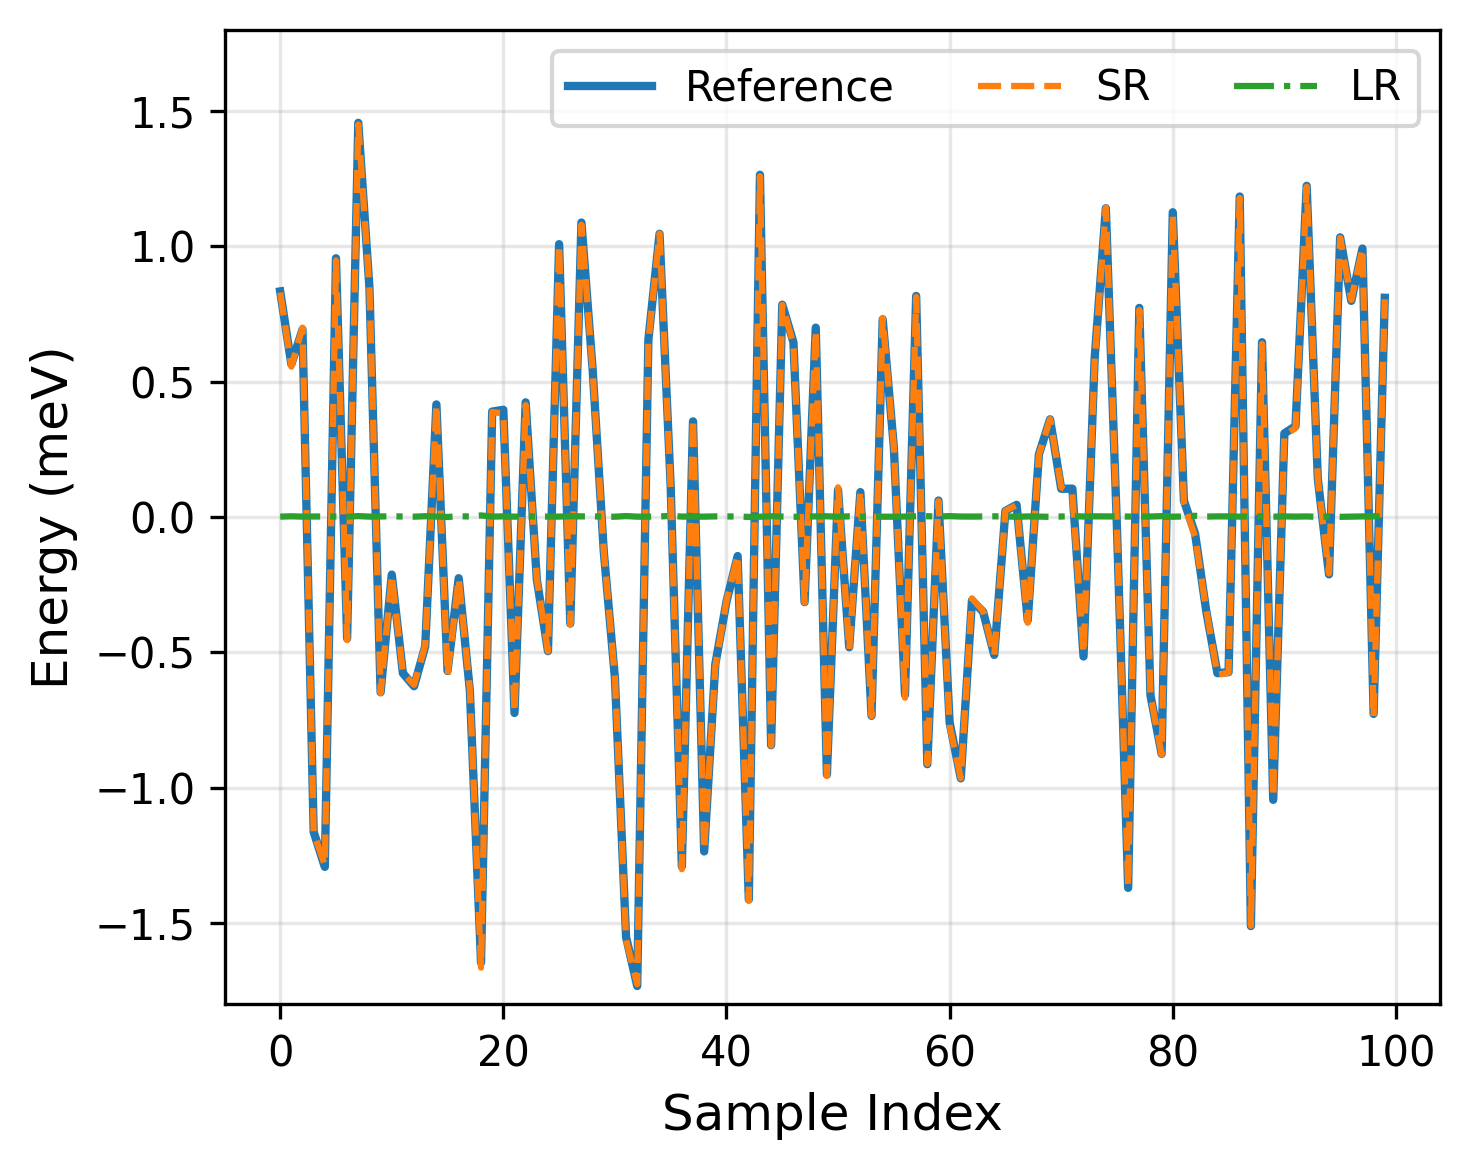

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4),dpi=300)

# Suppose the same length
steps = len(nn_energes)
x = np.arange(0, steps)

plt.plot(x, ref_energes, label='Reference', linewidth=2)
plt.plot(x, nn_energes_sr, '--', label='SR', linewidth=1.5)
plt.plot(x, nn_energes_lr, '-.', label='LR', linewidth=1.5)

plt.legend(loc='best',ncol=3, frameon=True)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Energy (meV)', fontsize=12)
# plt.title('Energy Components Comparison', fontsize=14)
plt.grid(alpha=0.3)
plt.ylim((-1.8,1.8))
plt.tight_layout()
plt.show()